In [1]:
# Final Project for ML class BIOF509 
# This project is trying to find the best method to predict whether the patient will get
# Dementia/Alzheimers or not given the data

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# merge two datasets
mri_cross = pd.read_csv('oasis_cross-sectional.csv', sep = ',')
mri_long = pd.read_csv('oasis_longitudinal.csv', sep = ',')
display(mri_cross.head(), mri_long.head())

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [2]:
# closer look to the score and labels
mri_long.groupby(['CDR', 'Group']).size().unstack()

Group,Converted,Demented,Nondemented
CDR,,,
0.0,18.0,NaN,188.0
0.5,19.0,102.0,2.0
1.0,NaN,41.0,NaN
2.0,NaN,3.0,NaN


In [3]:
# preprocessing the response variable
# In the longitudinal data, 'Converted' --> 'Dementated' according to the data descriptions
# encode CDR 0/0.5 --> 'Demented', 1/2 --> 'Nondemented'

In [4]:
# data summary (numerical)
mri_long.describe().round(1)

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.0,373.0,373.0,373.0,354.0,371.0,373.0,373.0,373.0,373.0
mean,1.9,595.1,77.0,14.6,2.5,27.3,0.3,1488.1,0.7,1.2
std,0.9,635.5,7.6,2.9,1.1,3.7,0.4,176.1,0.0,0.1
min,1.0,0.0,60.0,6.0,1.0,4.0,0.0,1106.0,0.6,0.9
25%,1.0,0.0,71.0,12.0,2.0,27.0,0.0,1357.0,0.7,1.1
50%,2.0,552.0,77.0,15.0,2.0,29.0,0.0,1470.0,0.7,1.2
75%,2.0,873.0,82.0,16.0,3.0,30.0,0.5,1597.0,0.8,1.3
max,5.0,2639.0,98.0,23.0,5.0,30.0,2.0,2004.0,0.8,1.6


In [5]:
predictors = ['Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
X = mri_long[predictors]
y = mri_long['Group']

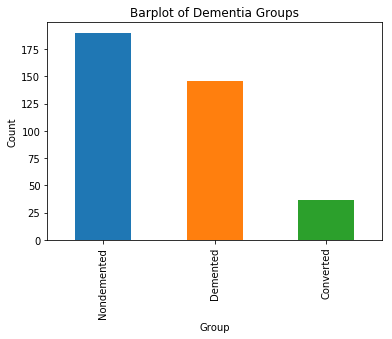

In [6]:
gd = y.value_counts().plot(kind = 'bar', title = 'Barplot of Dementia Groups')
gd.set_xlabel('Group')
gd.set_ylabel('Count')
plt.show()

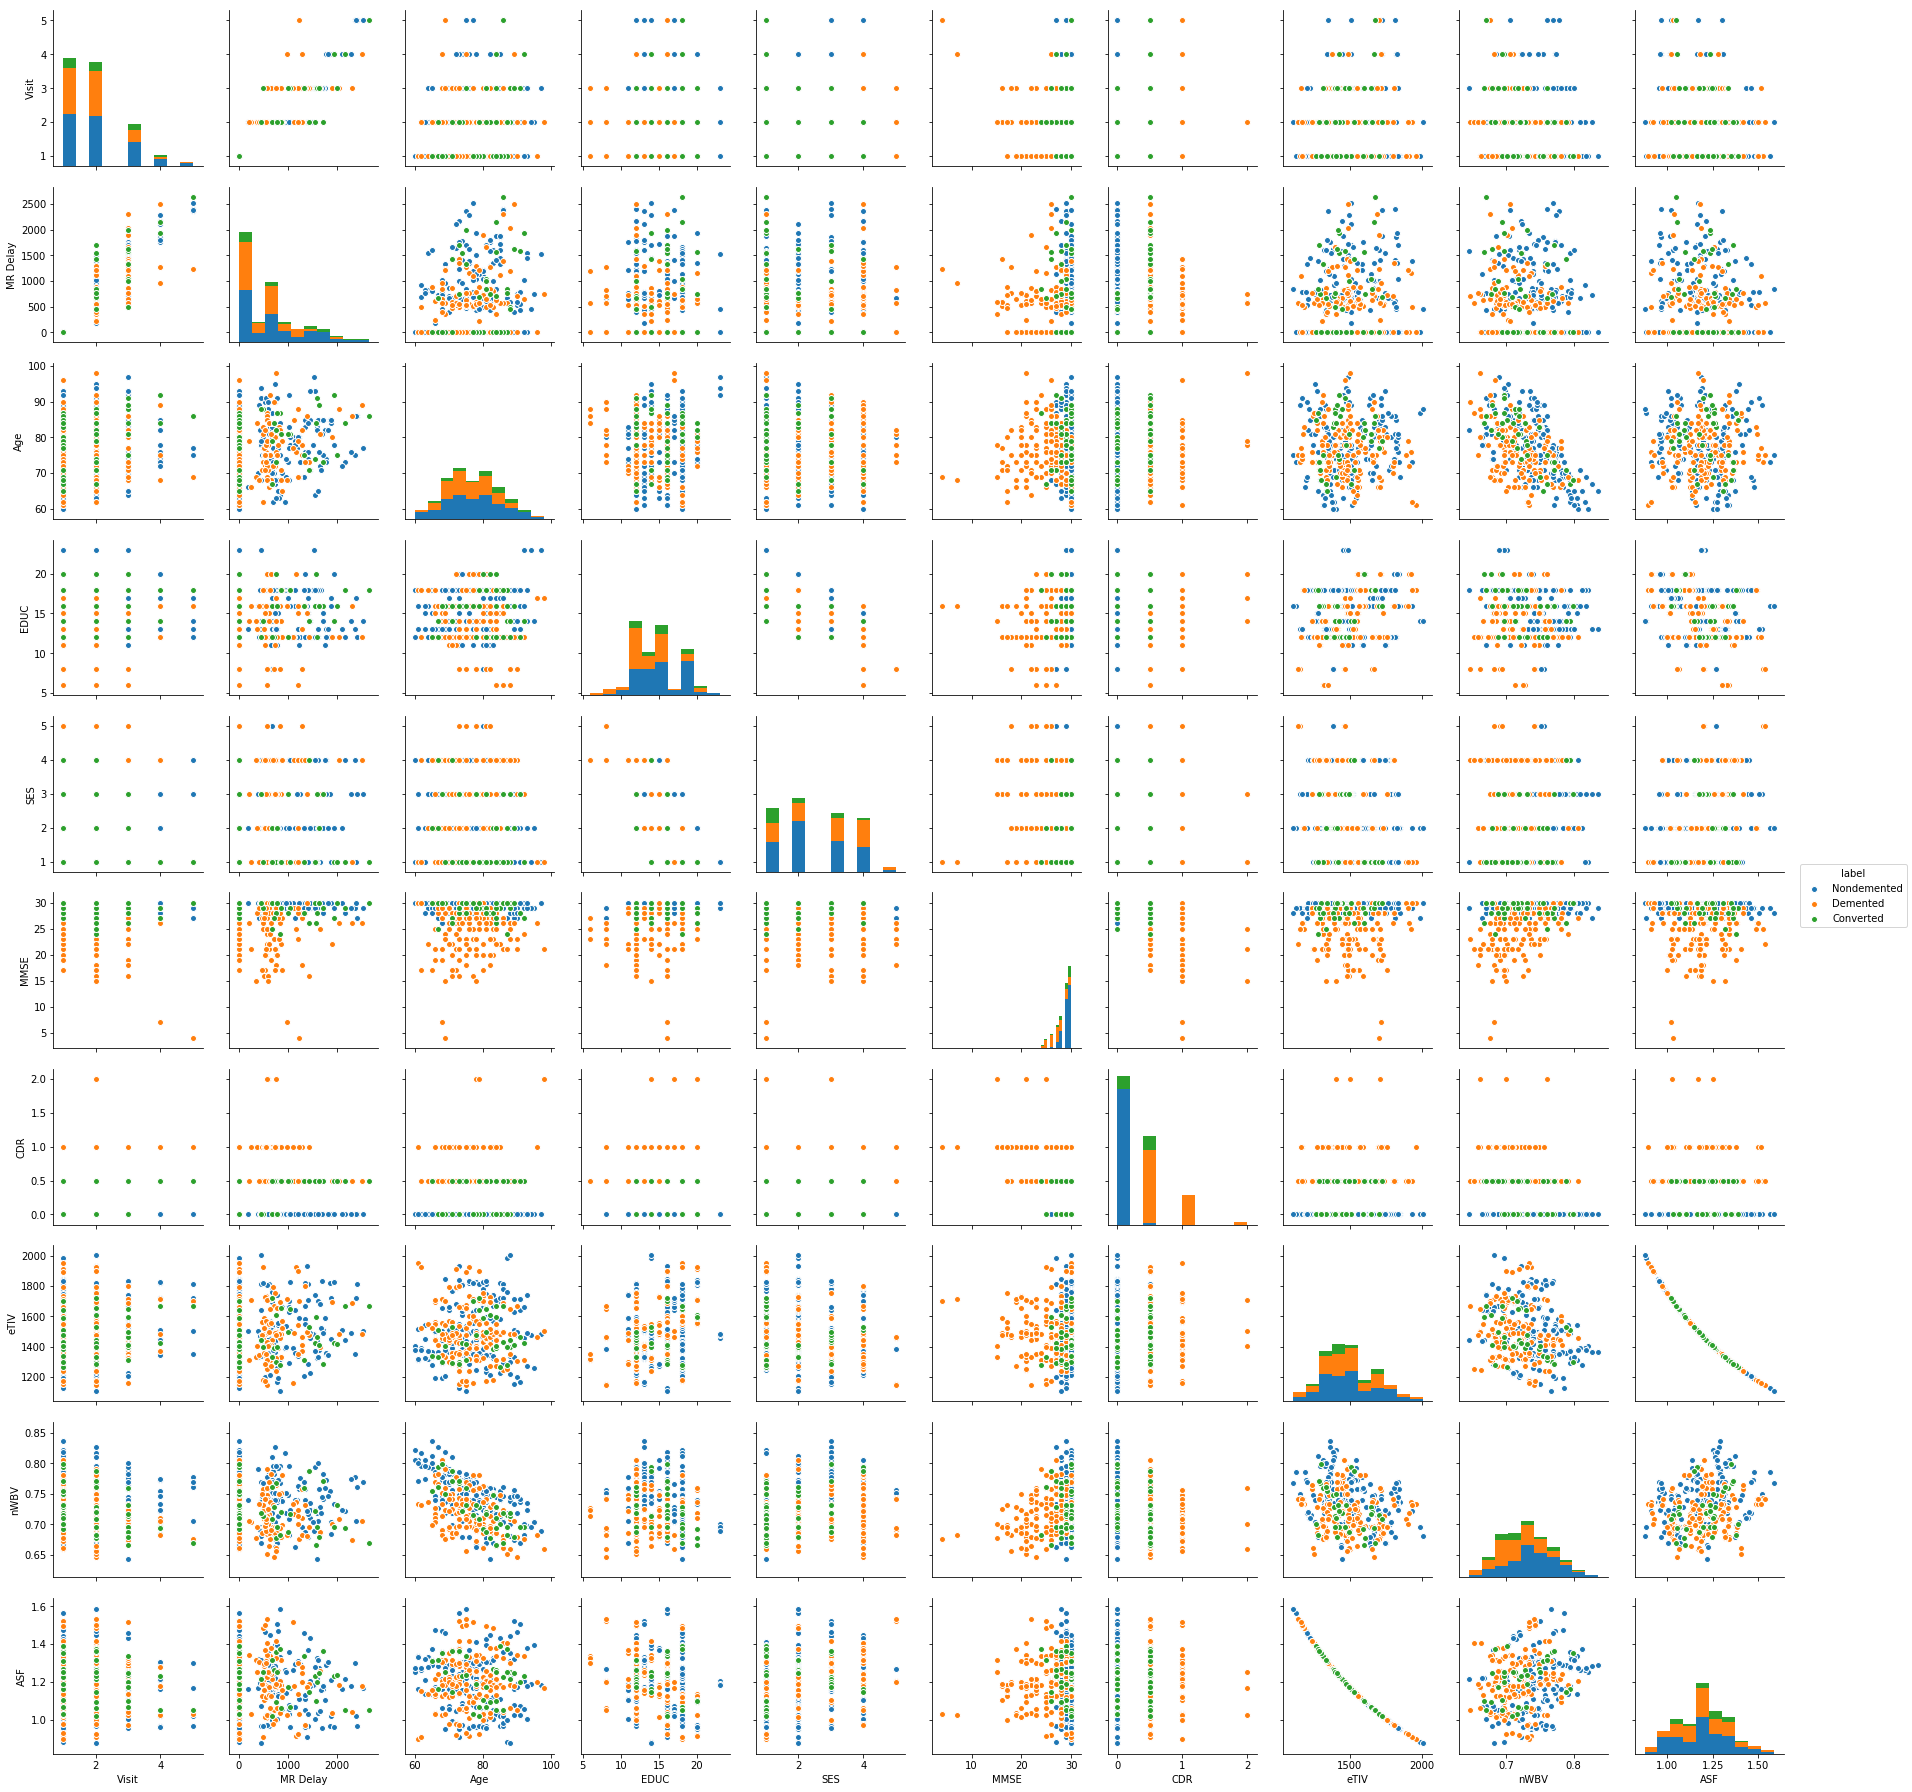

In [7]:
df_mri_long = pd.concat([pd.DataFrame(X), pd.DataFrame({'label': y})], axis = 1)
sns.pairplot(df_mri_long, hue = ('label'), )

In [8]:
# each individual's progress of dementia
# x = visit, y = each ind, color = group
# prog_y = mri_long[['Visit', 'Subject ID', 'Group']]
# prog_y[['Visit']] = prog_y[['Visit']].astype(object)
# plt.figure(figsize = (15, 20))
# sns.stripplot(x = 'Visit', y = 'Subject ID', hue = 'Group', jitter = False, data = prog_y)

In [9]:
prog_y.groupby(['Visit', 'Group']).size().unstack()

NameError: name 'prog_y' is not defined

In [ ]:
mri_long.groupby(['Subject ID', 'Group']).size().unstack()

In [ ]:
mri_cross = pd.read_csv('oasis_cross-sectional.csv', sep = ',')
print(mri_cross.shape)
print(mri_cross.dtypes)
# mri_cross.head()

predictors = ["M/F","Hand","Age","Educ","SES","MMSE","eTIV","nWBV","ASF"]
X = mri_cross[predictors]
y = mri_cross['CDR']

# look at the categorical predictors -- M/F and Hand
# number of female > male
gd = mri_cross['M/F'].value_counts().plot(kind = 'bar',
                                         title = 'Barplot of gender')
gd.set_xlabel('Gender')
gd.set_ylabel('Count')
plt.show()